In [177]:
import numpy as np
import matplotlib.pyplot as plt
import time

import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

In [228]:
def BoltzmannWeight_local(spins, sitex, sitey, K, h, T, dop_spacing, dop_val):
  sum=0

  K_dop_val=dop_val*K/T
  K_reg_val=1*K/T
    #assumes non periodic boundary conditions, should be fine to ignore in the large N limit
  if sitex % dop_spacing ==0 and sitey % dop_spacing ==0:
    K=K_dop_val
  else:
    K=K_reg_val
  if sitex == (len(spins)-1)  and sitey != len(spins)-1  and sitey !=0:
    #sum+=((K*spins[sitex][sitey]*spins[sitex+1][sitey]))
    sum+=((K*spins[sitex][sitey]*spins[sitex-1][sitey]))
    sum+=((K*spins[sitex][sitey]*spins[sitex][sitey+1]))
    sum+=((K*spins[sitex][sitey]*spins[sitex][sitey-1]))
  if sitey == len(spins)-1  and sitex != len(spins)-1 and sitex !=0:
    sum+=((K*spins[sitex][sitey]*spins[sitex+1][sitey]))
    sum+=((K*spins[sitex][sitey]*spins[sitex-1][sitey]))
    #sum+=((K*spins[sitex][sitey]*spins[sitex][sitey+1]))
    sum+=((K*spins[sitex][sitey]*spins[sitex][sitey-1]))
  if sitex ==0  and sitey != len(spins)-1 and sitey !=0:
    sum+=((K*spins[sitex][sitey]*spins[sitex+1][sitey]))
    #sum+=((K*spins[sitex][sitey]*spins[sitex-1][sitey]))
    sum+=((K*spins[sitex][sitey]*spins[sitex][sitey+1]))
    sum+=((K*spins[sitex][sitey]*spins[sitex][sitey-1]))
  if sitey==0 and sitex != len(spins)-1 and sitex !=0:
    sum+=((K*spins[sitex][sitey]*spins[sitex+1][sitey]))
    sum+=((K*spins[sitex][sitey]*spins[sitex-1][sitey]))
    sum+=((K*spins[sitex][sitey]*spins[sitex][sitey+1]))
    #sum+=((K*spins[sitex][sitey]*spins[sitex][sitey-1]))
  if sitex != len(spins)-1 and sitey != len(spins)-1 and sitex !=0 and sitey !=0:
    sum+=((K*spins[sitex][sitey]*spins[sitex+1][sitey]))
    sum+=((K*spins[sitex][sitey]*spins[sitex-1][sitey]))
    sum+=((K*spins[sitex][sitey]*spins[sitex][sitey+1]))
    sum+=((K*spins[sitex][sitey]*spins[sitex][sitey-1]))

  sum+=((h*spins[sitex][sitey]))
            #print(sum)
    #print(sum)
  BW=np.exp(sum)
  return BW



In [229]:
def genSamples_hits_dopants(N_lattice, num_samples, K, h, T, dop_spacing, E_in, hit_time):
    # number of sites in our 1D ising model
    #N_lattice = 12
    
    samples = np.zeros([num_samples, N_lattice, N_lattice]) # where you will store your samples

    for i in range((num_samples)):
      if i==0:
        #creat the lattice at "time step 1"
        spin_start= np.ones([N_lattice, N_lattice])
        
        samples[0]= spin_start
      if i>0:
        #samples[i]=samples[i-1]
        spin_start= samples[i-1].copy()
        #print(i, samples[i-1]-samples[i-2])
      if i==hit_time: #put the particle hit at time step hit_time
        #samples[i]=spin_start
        spin_start= samples[i-1].copy()
        #print(i, samples[i-1]-samples[i-2])
        hit_sitex=int(N_lattice/2)
        hit_sitey=int(N_lattice/2)
        spin_start[hit_sitex, hit_sitey]= -1
        for s_x in range(int(np.sqrt(E_in))+1): #s is number of particles ionized
          for s_y in range(int(np.sqrt(E_in))+1):
            spin_start[hit_sitex+s_x, hit_sitey+s_y] = -1
            

        samples[i]=spin_start
      
      for n in range(N_lattice): #number of possible flips
        #spin_start= samples[i]

        site= np.random.choice(N_lattice), np.random.choice(N_lattice)
        if i==hit_time and site== (hit_sitex, hit_sitey):
          site= np.random.choice(N_lattice), np.random.choice(N_lattice)
        #print(i, spin_start[site])
        #define the flipped spin_start
        pos_flip=spin_start.copy()
        #print(pos_flip[site])
        if pos_flip[site]==1:
          pos_flip[site]=-1
        else:
          pos_flip[site]=1
        #pos_flip[site]=-1*spin_start.copy()[site]

        #determine probability of flip - random num gen >A dont flip, random num gen < A, flip
        A= BoltzmannWeight_local(pos_flip, site[0], site[1], K, h, T, dop_spacing)/BoltzmannWeight_local(spin_start, site[0], site[1], K, h, T, dop_spacing)
        A=np.min([1,A])
        #print(A, BoltzmannWeight_dopants(pos_flip, K, h, T, dop_spacing), BoltzmannWeight_dopants(spin_start, K, h, T, dop_spacing))
        #print(n, A)
        prob =np.random.rand(1,1)
        #noise_prob=0.01*T #noise increases as temperature increases


        if prob <=A:
          #print(samples[i]-pos_flip)
          #print(pos_flip[site]-spin_start[site])
          spin_start = pos_flip
          
        else:
          spin_start =spin_start
          #print(A, prob, 'no flip')
      samples[i]=spin_start
    return samples

In [265]:
def genSamples_hits_dopants_proportional(N_lattice, num_samples, K, h, T, dop_spacing, dop_val, E_in, hit_time):
 
    samples = np.zeros([num_samples, N_lattice, N_lattice]) # where you will store your samples

    for i in range((num_samples)):
      if i==0:
        #creat the lattice at "time step 1"
        spin_start= np.ones([N_lattice, N_lattice])
        
        samples[0]= spin_start
      if i>0:
        #samples[i]=samples[i-1]
        spin_start= samples[i-1].copy()
        #print(i, samples[i-1]-samples[i-2])
      if i==hit_time: #put the particle hit at time step hit_time
        #samples[i]=spin_start
        spin_start= samples[i-1].copy()
        #print(i, samples[i-1]-samples[i-2])
        hit_sitex=int(N_lattice/2)
        hit_sitey=int(N_lattice/2)
        spin_start[hit_sitex, hit_sitey]= -1
        num_to_flip=E_in-1

        k=0 #make possible sites in a square
        sites=np.zeros([(int(np.sqrt(E_in))+1)**2, 2])
        for s_x in range(int(np.sqrt(E_in))+1): #s is number of particles ionized
          for s_y in range(int(np.sqrt(E_in))+1):
            sites[k] =[hit_sitex+s_x, hit_sitey+s_y]
            k+=1

        j=0 # only flip a number of them proportional to E_in
        while j <= num_to_flip:  
          sitex=int(sites[j][0])
          sitey=int(sites[j][1])
          spin_start[sitex,sitey]= -1
          j+=1
          #print(j, num_to_flip, hit_sitex, hit_sitey)

        samples[i]=spin_start
      
      for n in range(N_lattice): #number of possible flips
        #spin_start= samples[i]

        site= np.random.choice(N_lattice), np.random.choice(N_lattice)
        if i==hit_time and site== (hit_sitex, hit_sitey):
          site= np.random.choice(N_lattice), np.random.choice(N_lattice)
        #print(i, spin_start[site])
        #define the flipped spin_start
        pos_flip=spin_start.copy()
        #print(pos_flip[site])
        if pos_flip[site]==1:
          pos_flip[site]=-1
        else:
          pos_flip[site]=1
        #pos_flip[site]=-1*spin_start.copy()[site]

        #determine probability of flip - random num gen >A dont flip, random num gen < A, flip
        A= BoltzmannWeight_local(pos_flip, site[0], site[1], K, h, T, dop_spacing, dop_val)/BoltzmannWeight_local(spin_start, site[0], site[1], K, h, T, dop_spacing, dop_val)
        A=np.min([1,A])
        #print(A, BoltzmannWeight_dopants(pos_flip, K, h, T, dop_spacing), BoltzmannWeight_dopants(spin_start, K, h, T, dop_spacing))
        #print(n, A)
        prob =np.random.rand(1,1)
        #noise_prob=0.01*T #noise increases as temperature increases


        if prob <=A:
          spin_start = pos_flip
          
        else:
          spin_start =spin_start
          #print(A, prob, 'no flip')
      samples[i]=spin_start
    return samples


N_lattice = 100
n_samp=255
K=1
T=1
hit_time=300
E_hit=6
h=1

prop_samp= genSamples_hits_dopants_proportional(N_lattice, n_samp, K, h, T, 1, 1, E_hit, hit_time)
fig, ax = plt.subplots(figsize=(N_lattice, N_lattice))
ax.set(xlim=(0,N_lattice ), ylim=(0, N_lattice))

cax = ax.pcolormesh(prop_samp[250],vmin=-1, vmax=1, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_title(f"Temp= {T}, h= {h}", fontsize=100)

Text(0.5, 1.0, 'Temp= 1, h= 1')

In [235]:
#temp=np.linspace(1,1.5,10)
N_lattice = 100


n_samp=350
K=1
T=1
hit_time=50
E_hit=6

#test_dop_hits= genSamples_hits_dopants(N_lattice,n_samp, K, 1, T, 5, E_hit, hit_time)

#print(len(test_dop_hits))

In [188]:
def magnetization(spins_array):
    mag_vals = np.zeros(len(spins_array))
    tot_sites= N_lattice**2
    for i in range(len(spins_array)):
        mag_vals[i] = np.sum(spins_array[i])
    
    return np.abs((mag_vals-tot_sites)/tot_sites)*100


times=np.arange(0, len(test_dop_hits))
temps= [1,2,3]
num_runs= 100


for t in temps: 
    mag= np.zeros([num_runs, n_samp])
    magnet=np.zeros(n_samp)
    for r in range(num_runs):
        test_dop_hits= genSamples_hits_dopants(N_lattice,n_samp, K, 1, t, 5, E_hit, hit_time)
        #print(len(magnetization(test_dop_hits)))
        mag[r,]= magnetization(test_dop_hits) 
        #print(mag)
    
        magnet+=mag[r]
    magnet=magnet/num_runs
    #print(magnet)
    plt.plot(times, magnet, label=f"temp= {t}")


plt.xlabel('time step')
plt.ylabel('Number of atoms ionized [% of total atoms]')
plt.axvline(hit_time, 0, mag.max(), label="particle hit", color='purple', linestyle='--')
plt.legend()
plt.title(f"Lattice Size {N_lattice}x{N_lattice}, hit energy {E_hit}, number of runs per temp {num_runs} ")




KeyboardInterrupt: 

In [184]:
#dead time as a function of temperature
def dead_time(spins, E_in, hit_time):
    time_0=hit_time
    sites=np.zeros([(int(np.sqrt(E_in))+1)**2, 2])
    hit_sitex=int(N_lattice/2)
    hit_sitey=int(N_lattice/2)
    sites[0]= [hit_sitex, hit_sitey]
    i=0
    for s_x in range(int(np.sqrt(E_in))+1): #s is number of particles ionized
          for s_y in range(int(np.sqrt(E_in))+1):
            sites[i] =[hit_sitex+s_x, hit_sitey+s_y]
            i+=1
    #print(spins[sites[0]])
    dead=-len(sites)
    #while dead !=0:
    for time_step in range(len(spins)-hit_time):
      time_step+=hit_time
      
      for site in sites:
        #print(site)
        sitex=int(site[0])
        sitey=int(site[1])
        #print(sitex,sitey)
        if spins[time_step, sitex,sitey]==-1:
          dead+=0
        if spins[time_step, sitex,sitey]==1:
          dead+=1
        if dead==0: 
          time_stop= time_step
          dead_time= time_stop-time_0
          #print(dead, time_stop)
          #break
          continue
      #print(dead)
    #return dead_time
    return dead_time 



0.1 3.0
0.6444444444444445 2.9
1.188888888888889 2.8


KeyboardInterrupt: 

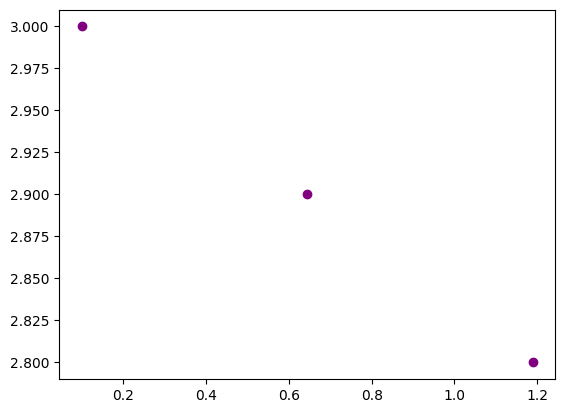

In [247]:
N_lattice = 100


n_samp=150
K=1
T=1
hit_time=50
E_hit=6

temps= np.linspace(0.1, 5, 10) #[1,2,3]
num_runs= 10
for t in temps: 
  dead_time_runs=0
  for r in range(num_runs):     
    test_dop_hits= genSamples_hits_dopants_proportional(N_lattice,n_samp, K, 1, t, 5,2, E_hit, hit_time)        
    dead_time_runs+=dead_time(test_dop_hits, E_hit, hit_time)
  dead_time_avg = dead_time_runs/num_runs
  print(t, dead_time_avg)
  plt.scatter(t, dead_time_avg, color='purple')

plt.xlabel('temperature')
plt.ylabel('Dead time [simulation seconds]')
plt.show()


temp deadtime
0.1 32.296
0.6444444444444445 31.398
1.188888888888889 26.31
1.7333333333333336 22.558
2.277777777777778 19.494
2.8222222222222224 19.11
3.366666666666667 19.182
3.911111111111112 18.886
4.455555555555556 19.11
5.0 18.288

1.0 1.0
2.0 1.0
3.0 1.0
4.0 1.0
5.0 1.94
6.0 2.91
7.0 3.81
8.0 7.85
9.0 3.98
10.0 8.4


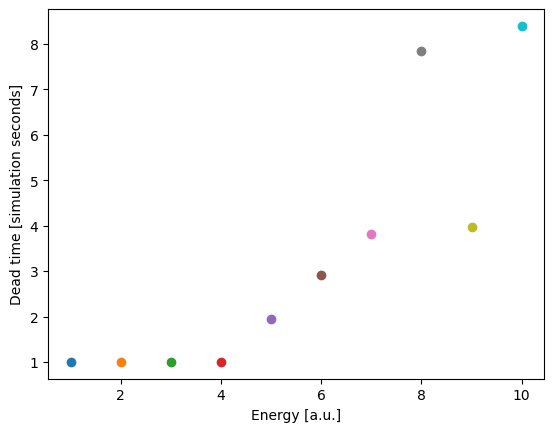

In [132]:
N_lattice = 100

n_samp=500
K=1
T=1
hit_time=150
E_hits=np.linspace(1,10, 10)

num_runs= 100
for E in E_hits: 
  dead_time_runs=0
  for r in range(num_runs):     
    test_dop_hits= genSamples_hits_dopants_proportional(N_lattice,n_samp, K, 1, T, 5, E, hit_time)        
    dead_time_runs+=dead_time(test_dop_hits, E_hit, hit_time)
  dead_time_avg = dead_time_runs/num_runs
  print(E, dead_time_avg)
  plt.scatter(E, dead_time_avg)

plt.xlabel('Energy [a.u.]')
plt.ylabel('Dead time [simulation seconds]')
plt.show()


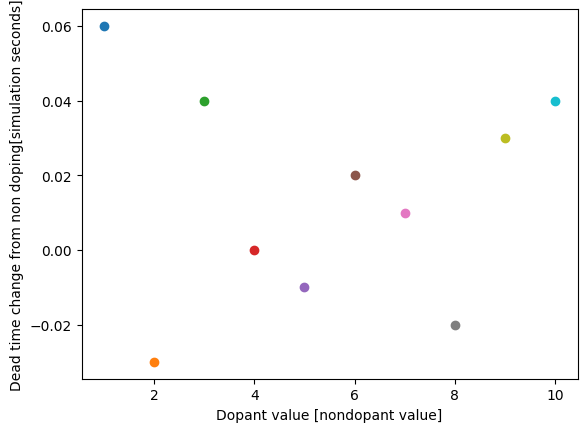

In [242]:
#dop_spacing
N_lattice = 100
n_samp=200
K=1
T=1
hit_time=50
E_hits=6
dop_spacing= 5
dop_val= np.linspace(1,10, 10)
num_runs= 100

dead_time_runs_nodop=0
for r in range(num_runs):     
    test_dop_hits= genSamples_hits_dopants_proportional(N_lattice,n_samp, K, 1, T, dop_spacing, 1, E_hits, hit_time)        
    dead_time_runs_nodop+=dead_time(test_dop_hits, E_hit, hit_time)
dead_time_no_dop_avg = dead_time_runs_nodop/num_runs


for d in dop_val: 
  dead_time_runs=0
  for r in range(num_runs):     
    test_dop_hits= genSamples_hits_dopants_proportional(N_lattice,n_samp, K, 1, T, dop_spacing, d, E_hits, hit_time)        
    dead_time_runs+=dead_time(test_dop_hits, E_hit, hit_time)
  dead_time_avg = dead_time_runs/num_runs
  
  plt.scatter(d, dead_time_avg-dead_time_no_dop_avg)

plt.xlabel('Dopant value [nondopant value]')
plt.ylabel('Dead time change from non doping[simulation seconds]')
plt.show()


0.1 0.1 [0.99968 0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.     ]
0.1 1.1473684210526316 [0.99968 0.99762 0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.     ]
0.1 2.194736842105263 [0.99968 0.99762 0.92146 0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.     ]
0.1 3.2421052631578946 [0.99968 0.99762 0.92146 0.68764 0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.     ]
0.1 4.289473684210526 [0.99968 0.99762 0.92146 0.68764 0.44948 0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.     ]
0.1 5.336842105263157 [0.99968 0.99762 0.92146 0.68764 0.44948 0.31916 0.      0.      0.
 0.      0.      0.      0.      0.      0

Text(0.5, 1.0, 'Lattice Size 100x100, number of runs per temp 10 ')

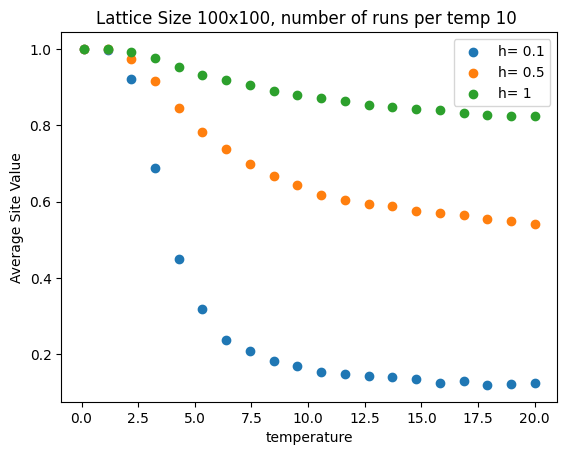

In [220]:
#testing to find a phase transition
def magnetization_attime(spins_array):
    # mag_vals = np.zeros(len(spins_array))
    tot_sites= N_lattice**2
    #for i in range(len(spins_array)):
    mag_val = np.sum(spins_array)
    #print(mag_val)
    return np.abs((mag_val)/tot_sites)

temps= np.linspace(0.1, 20, 20)
num_runs= 10
n_samp=502
hit_time=1000
K=1
hs=[0.1, 0.5, 1]

for h in hs:
    i=0
    magnet=np.zeros(len(temps))
    for t in temps: 

        mag= 0
        for r in range(num_runs):
            test_dop_hits= genSamples_hits_dopants(N_lattice,n_samp, K, h, t, 5, E_hit, hit_time)
            #print(len(magnetization(test_dop_hits)))
            #print(test_dop_hits[500,0])
            mag+= magnetization_attime(test_dop_hits[500]) 
            
        magnet[i]=mag/num_runs
        i+=1
        print(h, t, magnet)
    plt.scatter(temps, magnet, label=f"h= {h}")



plt.xlabel('temperature')
plt.ylabel('Average Site Value')
#plt.axvline(hit_time, 0, mag.max(), label="particle hit", color='purple', linestyle='--')
plt.legend()
plt.title(f"Lattice Size {N_lattice}x{N_lattice}, number of runs per temp {num_runs} ")




In [176]:
N_lattice=100
n_samp=100
E_hit=2
T=1
prop_samp= genSamples_hits_dopants_proportional(N_lattice, n_samp, 1,1,T,5,E_hit, 1)

fig, ax = plt.subplots(figsize=(N_lattice, N_lattice))
ax.set(xlim=(0,N_lattice ), ylim=(0, N_lattice))

cax = ax.pcolormesh(prop_samp[0],vmin=-2, vmax=1, cmap=plt.cm.Blues)
fig.colorbar(cax)
#plt.show()


def animate(i):
     cax.set_array(prop_samp[i].flatten())
     

     #print(i)
     #ax.text(0.05, 0.95, f'Time step: {i}', transform=ax.transAxes, va='top')
     #plt.suptitle(i)
     #cbar.set_title(f'Frame {i}')
     #ax.clear()
     if i==hit_time:
          ax.set_title(f"time = {i}, temp= {T}, hit, hit energy= {E_hit}", fontsize=60)
     else:
          ax.set_title(f"time = {i}, temp= {T}", fontsize=60)
          
     #ttl = ax.text(0.5, 1.005, i, transform = ax.transAxes, va='center', fontsize= 'medium')
     return cax


anim = FuncAnimation(fig, animate, interval=400, frames=(n_samp))

#plt.show()
#anim.save('test.mp4')
#anim.save('test.gif', writer='imagemagick')
anim.save('Ising_model_detector_testdeadtime.gif', writer = "pillow", fps=5 )

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (100000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
